## スリンキーを非線形格子波動として数値計算する

### その１〜初期配置の計算

In [1]:
#グラフを描画するための宣言
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

物体座標を$X$,空間座標を$x$、変位を$U$とすると、
$$
x=X+u
$$
変形勾配は
$$ F=\frac{\partial x}{\partial X}=1+\frac{\partial u}{\partial X}$$
である。
連続の式＝質量保存則は$\dot{m}=0$で
$$
m=\int{\rho_{0}}dX=\int{\rho}dx=\int{\rho}F dX
$$
だから
$$
F=\frac{\rho_{0}}{\rho}
$$
であって、
$$
\dot{\rho}F+\rho \dot{F}=0
$$
である。ここで、
$$
\dot{F}=\frac{\partial }{\partial t}\frac{\partial }{\partial X}(X+u)
=\frac{\partial }{\partial X}\frac{\partial }{\partial t}(X+u)
=\frac{\partial }{\partial X}\frac{\partial u}{\partial t}
=\frac{\partial }{\partial X}v
$$
であるから
$$
\dot{\rho}+\frac{\rho}{F}\frac{\partial }{\partial X}v
\tag{1}$$
これを物体表示での連続の式という

物体座標でのひずみは、
$$
dx\cdot dx' - dX\cdot  dX'=FdX \cdot F dX' - dX\cdot dX' = dX \cdot (F^2 -1)\cdot dX' \equiv dX \cdot 2E \cdot dX' 
$$
と定義して、
$$
E=\frac{1}{2}(F^2 -1)=\frac{1}{2}\left(\left(1+ \frac{\partial u}{\partial X}\right)^2 -1\right)
\tag{2}$$
をGreen-Lagrangeひずみという。
物体座標での応力は第１Piola–Kirchihoff応力テンソル$P$と第１Piola–Kirchihoff応力テンソル$S$があって、
$P$が物体表示での運動方程式
$$
\rho_{0}\frac{\partial v}{\partial t}=\frac{\partial P}{\partial X}+\rho_{0}b
\tag{3}$$
$S$が物体表示での構成式
$$
S=T(E)
\tag{4}$$
で必要とされる。今回は$T$は線形な関数であると仮定して、
$$
S=GE
\tag{5}$$
とする。$P$と$S$の関係は$P=SF$であるので、運動方程式は
$$
\rho_{0}\frac{\partial v}{\partial t}=G\frac{\partial }{\partial X}(SF)+\rho_{0}b = G\frac{\partial }{\partial X} \left(F \frac{F^2-1}{2} 
\right ) + \rho_{0}b
\tag{6}$$
となる。

以上をまとめると、物体表示での基本となる式は
$$
x=X+u\tag{定義1}$$
$$ 
F=1+\frac{\partial u}{\partial X}\tag{定義2}$$
$$
\rho=\frac{\rho_{0}}{F}\tag{定義3}$$
$$
\frac{\partial F}{\partial t}=\frac{\partial v}{\partial X}
\tag{方程式1}$$
$$
\rho_{0}\frac{\partial v}{\partial t} =  G\frac{\partial }{\partial X} \left(F \frac{F^2-1}{2} 
\right ) + \rho_{0}b
\tag{方程式2}$$
の５つとなる。

問題は、重力場でこの物体を上から吊り下げて静止させておいて、ある瞬間に手を離して落下するときの物体各点の運動を求めることである。
数値計算で求めるので、方程式は離散化する必要がある。まず、空間を離散化した方程式を作る。これは、非線形バネでつながれた多数の質点の運動の問題に等しい。連続体の方程式を、変位に関する形にすれば
$$
\rho_{0}\frac{\partial^2 u}{\partial t^2}=
G\frac{\partial }{\partial X}\left(  \left(  \frac{\partial u}{\partial X}\right) + \frac{3}{2}\left( \frac{\partial u}{\partial X}\right)^2 + \frac{1}{2}\left( \frac{\partial u}{\partial X}\right)^3 \right)  - \rho_{0}g
\tag{方程式3}$$
となる。これを、質点形のモデルにすると
$$
m\ddot{q_n}=
k\left(  f(q_{n+1} - q_{n} ) - f(q_{n} - q_{n-1} )\right)  - mg
\tag{4-1}$$
$$
f(r_n)=C+r_n+\frac{3}{2}r_n^2+\frac{1}{2}r_n^3 ,\quad r_n=q_{n+1} -q_n
\tag{4-2}$$
という形になる。バネの力での、相対変位の２乗や３乗の項が非線形性をあらわしている。ただしここで注意するのは、バネの力に任意の定数$C$が付いていることである。この項があっても、物体内部の運動方程式は変わらないのだが、  
①この系のラグランジアンを考えた時に、ポテンシャルが$C$の値によって、停留値が１つだけか２つあるのかが変わる。  
②境界条件は$C$の値に依存する。  
こういう理由があるので、$C$の値をどうするかで結果は変わる。  
今回は$C=-3$として計算することにする。
$$
f(r_n)=-3+r_n+\frac{3}{2}r_n^2+\frac{1}{2}r_n^3 ,\quad r_n=q_{n+1} -q_n
\tag{5}$$
上から吊り下げて停止している時には
$$
0=
 f(q_{2} - q_{1} ) - \frac{mg}{k}
\tag{6-1}$$
$$
0= f(q_{n+1} - q_{n} ) - f(q_{n} - q_{n-1} ) - \frac{mg}{k}
\tag{6-2}$$
$$
0= T - f(q_{N} - q_{N-1} ) - \frac{mg}{k}
\tag{6-3}$$

まず、練習で$g=0$の場合を計算してみる。$f(x)=Const.$の解を求めるのには、ニュートン法を使う。

In [2]:
#3次方程式f(x)=Ax^3+Bx^2+Cx+D=0をニュートン法で解く
def Newton(a,b,c,d):
    x=-d/c
    for i in range(10):
        dx= -(a*x*x*x + b*x*x + c*x + d)/(3*a*x*x + 2*b*x + c*x)
        x=x+dx
        #
    #
    return x

In [3]:
N=1000 #質点の数
n=np.arange(1,N+1)

In [4]:
n.size

1000

In [5]:
A= 1/2
B= 3/2
C= 1
D= -3

In [6]:
q=np.zeros(N)
q.size

1000

In [7]:
r=np.zeros(N)
r.size

1000

In [8]:
q[0]=0 #下端の値

In [9]:
g=0 #重力はゼロとした
for i in range(0,N-1):
    r[i]=Newton(A,B,C,D-i*g)
    q[i+1]=q[i]+r[i]
#
i=N-1
r[i]=Newton(A,B,C,D-i*g)
T=i*g
print("T=",T)

T= 0


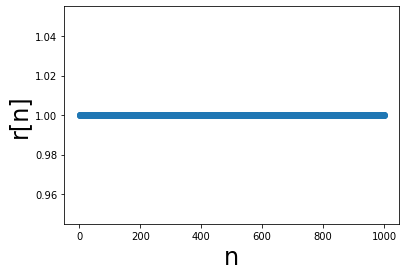

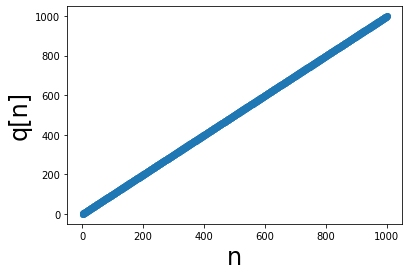

In [10]:
#グラフプロット
plt.plot (n, r, 'o')
plt.xlabel("n",  fontsize=24)
plt.ylabel("r[n]",  fontsize=24)
plt.show()
plt.plot (n, q, 'o')
plt.xlabel("n",  fontsize=24)
plt.ylabel("q[n]",  fontsize=24)
plt.show()

In [11]:
g=1 #重力あり
for i in range(0,N-1):
    r[i]=Newton(A,B,C,D-i*g)
    q[i+1]=q[i]+r[i]
#
i=N-1
r[i]=Newton(A,B,C,D-i*g)
T=i*g
print("T=",T)

T= 999


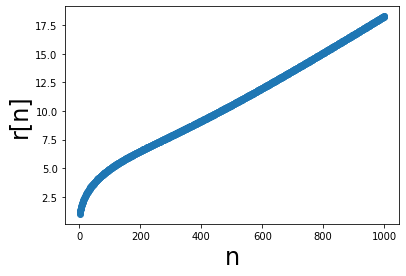

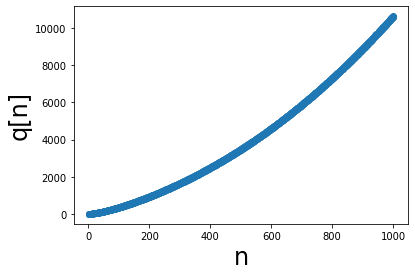

In [12]:
#グラフプロット
plt.plot (n, r, 'o')
plt.xlabel("n",  fontsize=24)
plt.ylabel("r[n]",  fontsize=24)
plt.show()
plt.plot (n, q, 'o')
plt.xlabel("n",  fontsize=24)
plt.ylabel("q[n]",  fontsize=24)
plt.show()

**重力場が非常に小さかったり、バネ定数が非常に大きければ、バネは均等に伸びは均一になる。特にバネ定数はあるが重力がない場合の結果には、「バネの自然長」が表れており、重力場のために下端の密度は濃く、上端の密度が薄く不均一な分布をなし、全体の長さは自然長の数倍にもなっている。**

ただし、今計算した$q_n$は空間上の位置ではなくて変位である。あらためて空間上の位置を、重力のある時とない時両方を求めてグラフを書いておく。

In [13]:
g=0 #重力はゼロとした
for i in range(0,N-1):
    r[i]=Newton(A,B,C,D-i*g)
    q[i+1]=q[i]+r[i]
#
i=N-1
r[i]=Newton(A,B,C,D-i*g)
T=i*g
print("T=",T)

T= 0


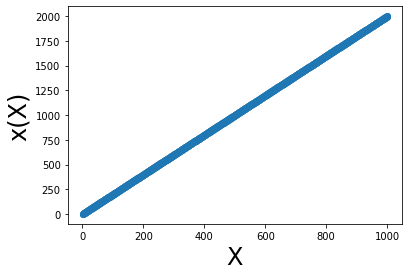

In [14]:
#グラフプロット
plt.plot (n, n+q, 'o')
plt.xlabel("X",  fontsize=24)
plt.ylabel("x(X)",  fontsize=24)
plt.show()

In [15]:
g=1 #重力あり
for i in range(0,N-1):
    r[i]=Newton(A,B,C,D-i*g)
    q[i+1]=q[i]+r[i]
#
i=N-1
r[i]=Newton(A,B,C,D-i*g)
T=i*g
print("T=",T)

T= 999


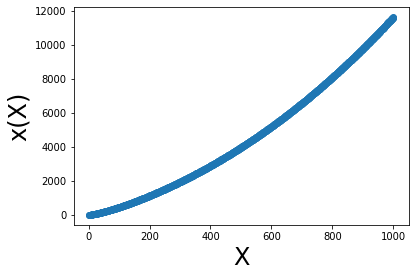

In [16]:
#グラフプロット
plt.plot (n, n+q, 'o')
plt.xlabel("X",  fontsize=24)
plt.ylabel("x(X)",  fontsize=24)
plt.show()